## Sep 15, 2023

### Visualize supervision + inference

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm
from PIL import Image
from IPython.core.display import display

os.chdir('..')
np.set_printoptions(precision=4)
!pwd

/home/ubuntu/workspace/dd3d


In [2]:
import numpy as np
import torch

def to_numpy(tensor):
    return tensor.permute(1, 2, 0).numpy()

def to_uint8(array):
    return (array * 255.0).astype(np.uint8)


In [3]:
# The Compose API is useful when @hydra.main() is not applicable.
# https://hydra.cc/docs/advanced/compose_api/

from hydra import initialize, compose

with initialize(config_path="../configs/"):
    cfg = compose(
        config_name="visualize_dataloader",
        overrides=[
            "+experiments=dd3d_kitti_dla34",
            "TEST.IMS_PER_BATCH=1",
            "DATASETS.TEST.NAME=kitti_3d_train",
        ]
    )

In [4]:
from tridet.data.datasets import register_datasets
from tridet.utils.setup import setup

setup(cfg)
try:
    dataset_names = register_datasets(cfg)
except AssertionError as e:
    print(e)

print(f"Registered {len(dataset_names)} datasets:" + '\n\t' + '\n\t'.join(dataset_names))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:03<00:00, 35.59it/s]
Using previously cached COCO format annotations at '/tmp/kitti_3d_train_coco_format.json'. You need to clear the cache file if your dataset has been modified.


Registered 1 datasets:
	kitti_3d_train


In [5]:
from detectron2.data import MetadataCatalog

from tridet.data import build_test_dataloader, build_train_dataloader
from tridet.data.dataset_mappers import get_dataset_mapper

# Use testset
# dataset_name = cfg.DATASETS.TEST.NAME
dataset_name = cfg.DATASETS.TRAIN.NAME
mapper = get_dataset_mapper(cfg, is_train=False)

print(dataset_name)

kitti_3d_train


In [6]:
import torch
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.common import DatasetFromList, MapDataset

# dataloader, dataset_dicts = build_test_dataloader(cfg, dataset_name, mapper=mapper)

def trivial_batch_collator(batch):
    """
    A batch collator that does nothing.
    """
    return batch

dataset_dicts = DatasetCatalog.get(dataset_name)
assert len(dataset_dicts), "Dataset '{}' is empty!".format(dataset_name)

dataset = DatasetFromList(dataset_dicts, copy=False)
dataset = MapDataset(dataset, mapper)

batch_size = cfg.TEST.IMS_PER_BATCH

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=cfg.DATALOADER.TEST.NUM_WORKERS,
#         batch_sampler=batch_sampler,
    collate_fn=trivial_batch_collator,
    pin_memory=True
)

In [7]:
visualizer_names = MetadataCatalog.get(cfg.DATASETS.TRAIN.NAME).loader_visualizers

In [8]:
KITTI_ROOT = 'KITTI3D'


mv3d_split = 'val' if 'val' in dataset_name else 'train'
with open(os.path.join(cfg.DATASET_ROOT, KITTI_ROOT, "mv3d_kitti_splits", "{}.txt".format(mv3d_split))) as _f:
    lines = [l.rstrip('\n') for l in _f.readlines()]

# # lines

# interesting_example_indices = []
# for fidx in interesting_images_png:    
#     filename = '{:06d}'.format(fidx)
#     if filename in lines:
#         interesting_example_indices.append((lines.index(filename), filename))
# interesting_example_indices

In [9]:
bidx = lines.index('{:06d}'.format(49))
batch = trivial_batch_collator([dataset[bidx]])

In [10]:
bidx = lines.index('{:06d}'.format(49))
batch = trivial_batch_collator([dataset[bidx]])

In [11]:
from collections import defaultdict
from tridet.visualizers import get_dataloader_visualizer
from tridet.utils.visualization import mosaic

viz_images = defaultdict(dict)

gts = []
for viz_name in visualizer_names:
    viz = get_dataloader_visualizer(cfg, viz_name, cfg.DATASETS.TRAIN.NAME)
    for idx, x in enumerate(batch):
        viz_images[idx].update(viz.visualize(x))
        
    for k in range(len(batch)):
        gt_viz = mosaic(list(viz_images[k].values()), scale=0.5, grid_width=1)
        gts.append(gt_viz)

In [12]:
# batch[0]['file_name']

In [13]:
visualizer_names

('d2_visualizer', 'box3d_visualizer')

In [14]:
from collections import defaultdict
from tridet.visualizers import get_dataloader_visualizer
from tridet.utils.visualization import mosaic

viz_images = defaultdict(dict)

gts = []
for viz_name in visualizer_names:
    viz = get_dataloader_visualizer(cfg, viz_name, cfg.DATASETS.TRAIN.NAME)
    for idx, x in enumerate(batch):
        viz_images[idx].update(viz.visualize(x))
        
    for k in range(len(batch)):
        gt_viz = mosaic(list(viz_images[k].values()), scale=0.5, grid_width=1)
        gts.append(gt_viz)

## Visualize GT

In [15]:
cols = [
    'name',
    'truncation',
    'occlusion',
    'alpha',
    'x1',
    'y1',
    'x2',
    'y2',
    'h',
    'w',
    'l',
    't1',  # x (of 3D bbox)
    't2',  # y (of 3D bbox)
    't3',  # z (of 3D bbox)
    'ry',  # rotation (of 3D bbox)
]

batch[0]['raw_kitti_annotations'].columns = cols
batch[0]['raw_kitti_annotations']

name  truncation  occlusion  alpha      x1      y1       x2      y2  \
0          Car        0.00          0  -1.57  595.50  177.15   657.31  227.34   
1          Car        0.00          0  -2.24  305.23  179.59   494.97  263.68   
2          Car        0.00          2  -2.14  410.09  176.18   514.77  228.78   
3          Car        0.00          2  -2.25  435.96  173.60   537.84  218.33   
4          Car        0.00          2  -2.24  473.64  171.53   556.16  203.86   
5          Van        0.00          3  -2.28  515.19  156.84   585.71  193.55   
6   Pedestrian        0.29          3  -2.06  984.43  188.05  1128.77  374.00   
7          Car        0.00          1  -1.98  823.97  189.33  1083.14  327.79   
8          Car        0.00          1  -1.83  753.34  185.35   885.42  263.59   
9          Car        0.00          2  -1.78  719.83  169.31   816.44  238.11   
10  Pedestrian        0.00          0  -1.88  693.57  173.32   709.90  209.83   
11         Car        0.00          2  -0.38  776.77  170.97   882.28  211.70   
12         Car        0.07          3   2.26    0.00  178.64   252.92  280.60   
13         Car        0.00          1   2.19  194.14  174.89   341.99  241.74   
14         Car        0.00          2  -1.56  603.49  171.71   639.30  204.36   
15         Car        0.00          2   1.90  287.85  175.62   379.41  228.84   
16         Van        0.00          3  -0.48  881.73  155.07  1040.99  215.24   
17         Car        0.38          3   2.23    0.00  170.48   111.64  240.66   
18    DontCare       -1.00         -1 -10.00  362.69  159.40   400.23  185.48   

       h     w     l       t1       t2       t3     ry  
0   1.36  1.69  3.38     0.45     1.51    21.55  -1.55  
1   1.40  1.60  3.55    -4.10     1.55    13.75  -2.52  
2   1.46  1.49  3.40    -4.55     1.58    21.82  -2.34  
3   1.43  1.62  3.47    -4.31     1.48    24.83  -2.43  
4   1.37  1.55  3.96    -4.36     1.34    32.49  -2.37  
5   2.21  1.82  4.69    -3.84     1.28    45.70  -2.36  
6   1.54  0.84  0.75     2.77     1.65     4.71  -1.55  
7   1.41  1.61  3.71     4.16     1.66     9.53  -1.58  
8   1.36  1.59  3.85     4.10     1.64    14.89  -1.57  
9   1.72  1.79  3.94     4.26     1.66    20.20  -1.58  
10  1.61  0.74  1.08     3.96     1.64    32.55  -1.76  
11  1.70  1.77  4.06     9.60     1.65    31.83  -0.09  
12  1.41  1.58  3.90    -7.94     1.52    12.04   1.69  
13  1.44  1.58  3.25    -8.06     1.50    17.23   1.75  
14  1.52  1.67  3.61     0.55     1.49    35.67  -1.54  
15  1.45  1.47  3.52    -8.24     1.56    21.69   1.55  
16  2.51  2.46  5.85    15.45     1.79    32.04  -0.03  
17  1.53  1.53  3.45   -14.04     1.50    17.43   1.56  
18 -1.00 -1.00 -1.00 -1000.00 -1000.00 -1000.00 -10.00

In [16]:
Image.fromarray(to_numpy(batch[0]['image'])[:,:,(2,1,0)])

In [17]:
import cv2
from PIL import Image

W = 1284
func_resize = lambda x: cv2.resize(x, None, fx=W/x.shape[1], fy=W/x.shape[1])

Image.fromarray(
    func_resize(gts[-1])
)

## Visualize supervision

In [18]:
from detectron2.modeling import build_model
from tridet.modeling import build_tta_model

model = build_model(cfg)

In [19]:
from tridet.utils.tensor2d import compute_features_locations as compute_locations_per_level

dtype = torch.float
device = torch.device('cpu')

def compute_locations(backbone_output_shape, feature_locations_offset, feature_shapes):
    locations = []
    in_strides = [x.stride for x in backbone_output_shape]
    for level, (h, w) in enumerate(feature_shapes):
        locations_per_level = compute_locations_per_level(
            h, w, in_strides[level], dtype, device, offset=feature_locations_offset
        )
        locations.append(locations_per_level)
    return locations

In [20]:
from tridet.modeling.dd3d.prepare_targets import DD3DTargetPreparer

## Settings
input_shape = batch[0]['image'].shape[-2:]
num_classes = cfg.DD3D.NUM_CLASSES
feature_shapes = [
    (48, 160), (24, 80), (12, 40), (6, 20), (3, 10)
]
gt_instances = [x["instances"].to(device) for x in batch]
backbone_output_shape = model.backbone_output_shape
feature_locations_offset = model.feature_locations_offset

## Prepare targets
locations = compute_locations(backbone_output_shape, feature_locations_offset, feature_shapes)
num_locations = [0] + [loc.shape[0] for loc in locations]
func_prepare_targets = DD3DTargetPreparer(cfg, backbone_output_shape)
targets = func_prepare_targets(locations, gt_instances, feature_shapes)

## Instance IDs

torch.Size([1, 3, 48, 160])


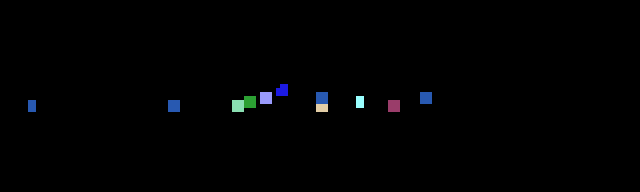

torch.Size([1, 3, 24, 80])


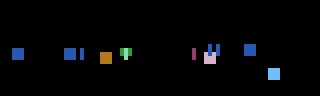

torch.Size([1, 3, 12, 40])


torch.Size([1, 3, 6, 20])


torch.Size([1, 3, 3, 10])


In [21]:
from matplotlib import cm

colormap = cm.get_cmap('Paired')

images = [to_numpy(batch[0]['image'].clone()) for _ in range(len(locations))]

## Construct target map
target_inds = targets['target_inds'].long()
pos_inds = targets['pos_inds'].long()

cls_target_inds = torch.zeros((sum(num_locations), 3), dtype=torch.uint8)
cls_target_inds[pos_inds] = torch.from_numpy((colormap(target_inds[pos_inds])[:, :3] * 255.0).astype(np.uint8))

acc_num_loc = np.cumsum(num_locations)
cls_target_inds_maps = []
for idx in range(1, len(num_locations)):    
    fh, fw = feature_shapes[idx-1]
    cls_target_inds_maps.append(
        cls_target_inds[acc_num_loc[idx-1]:acc_num_loc[idx]].reshape(1, fh, fw, 3).permute(0, 3, 1, 2)
    )

    print(cls_target_inds_maps[-1].shape)
    
    supervision = cv2.resize(
            to_numpy(cls_target_inds_maps[-1][0]).astype(np.uint8),
        None, fx=4.0, fy=4.0, interpolation=cv2.INTER_NEAREST)

    display(Image.fromarray(supervision[:,:,(2,1,0)]))
    img_supervision = cv2.resize(
        images[idx-1], (supervision.shape[1], supervision.shape[0]), interpolation=cv2.INTER_NEAREST
    )
    img_supervision[supervision > 0] = supervision[supervision > 0]
    display(Image.fromarray(img_supervision[:,:,(2,1,0)]))

## Regression targets

tensor([-0.9300, -0.9300, -0.9300, -0.9300, -0.9300, -0.9300, -0.0300, -0.0300,
        -0.0300, -0.9300, -0.9300, -0.9300, -0.0300, -0.0300, -0.0300, -0.0500,
        -0.0500, -0.0500,  0.0500,  0.0500,  0.0500, -0.0300, -0.0300, -0.0300,
        -0.0300, -0.0300, -0.0300,  0.0300,  0.0300, -0.0500, -0.0500, -0.0500,
        -0.0300, -0.0300,  0.1100,  0.1100,  0.1100,  0.1200,  0.1200,  0.1200,
         0.0500,  0.0500,  0.0500, -0.0300, -0.0300, -0.0300, -0.0300, -0.0300,
        -0.0300,  0.0300,  0.0300, -0.0600, -0.0600, -0.0600, -0.0500, -0.0500,
        -0.0500, -0.0300, -0.0300,  0.1100,  0.1100,  0.1100,  0.1200,  0.1200,
         0.1200,  0.0500,  0.0500,  0.0500,  0.1500,  0.1500,  0.1500,  0.0300,
         0.0300, -0.0600, -0.0600, -0.0600, -0.0300, -0.0300,  0.1100,  0.1100,
         0.1100,  0.1200,  0.1200,  0.1200,  0.1500,  0.1500,  0.1500, -0.0600,
        -0.0600, -0.0600, -0.0500, -0.0500, -0.7200, -0.7200, -0.7200, -0.0300,
        -0.0300, -0.0300,  0.0600,  0.06

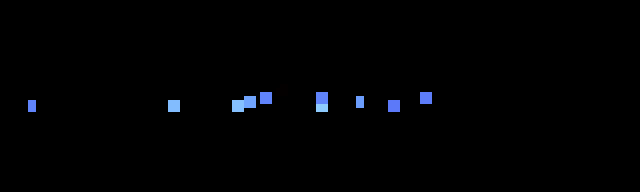

torch.Size([1, 3, 24, 80])


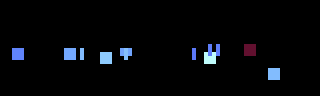

torch.Size([1, 3, 12, 40])


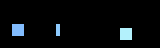

torch.Size([1, 3, 6, 20])


torch.Size([1, 3, 3, 10])


In [22]:
from matplotlib import cm

colormap = cm.get_cmap('magma')


images = [to_numpy(batch[0]['image'].clone()) for _ in range(len(locations))]

## Construct target map
# target_vals = targets['box2d_reg_targets'][:, 2].clone()
target_vals = targets['box3d_targets'].corners[:, 4, 1].clone()
pos_inds = targets['pos_inds'].long()

# Normalize for visualization
print(target_vals[pos_inds])
target_vals[pos_inds] = (target_vals[pos_inds] - target_vals[pos_inds].min()) / (target_vals[pos_inds].max() - target_vals[pos_inds].min())


target_supervision = torch.zeros((sum(num_locations), 3), dtype=torch.uint8)
target_supervision[pos_inds] = torch.from_numpy((colormap(target_vals[pos_inds])[:, :3] * 255.0).astype(np.uint8))

acc_num_loc = np.cumsum(num_locations)
supervision_maps = []
for idx in range(1, len(num_locations)):    
    fh, fw = feature_shapes[idx-1]
    supervision_maps.append(
        target_supervision[acc_num_loc[idx-1]:acc_num_loc[idx]].reshape(1, fh, fw, 3).permute(0, 3, 1, 2)
    )

    print(supervision_maps[-1].shape)
    
    supervision = cv2.resize(
            to_numpy(supervision_maps[-1][0]).astype(np.uint8),
#         (1272, 384), interpolation=cv2.INTER_NEAREST)
        None, fx=4.0, fy=4.0, interpolation=cv2.INTER_NEAREST)

    display(Image.fromarray(supervision[:,:,(2,1,0)]))
    img_supervision = cv2.resize(
        images[idx-1], (supervision.shape[1], supervision.shape[0]), interpolation=cv2.INTER_NEAREST
    )
    img_supervision[supervision > 0] = supervision[supervision > 0]
    display(Image.fromarray(img_supervision[:,:,(2,1,0)]))
    

torch.Size([1, 5, 48, 160])


torch.Size([1, 5, 24, 80])


torch.Size([1, 5, 12, 40])


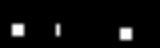

torch.Size([1, 5, 6, 20])


torch.Size([1, 5, 3, 10])


In [23]:
## Construct target map
labels = targets['labels']
pos_inds = targets["pos_inds"]

# cls_target = torch.zeros_like(logits)
cls_target = torch.zeros((sum(num_locations), num_classes), dtype=torch.uint8)
cls_target[pos_inds, labels[pos_inds]] = 1

acc_num_loc = np.cumsum(num_locations)
cls_target_maps = []
for idx in range(1, len(num_locations)):    
    fh, fw = feature_shapes[idx-1]
    cls_target_maps.append(
        cls_target[acc_num_loc[idx-1]:acc_num_loc[idx]].reshape(1, fh, fw, num_classes).permute(0, 3, 1, 2)
    )

    print(cls_target_maps[-1].shape)
    
    display(Image.fromarray(
        cv2.resize(
            (cls_target_maps[-1][0].sum(axis=0).numpy().astype(np.uint8) * 255)
        , None, fx=4.0, fy=4.0)
    ))

In [24]:
metadata = MetadataCatalog.get(cfg.DATASETS.TEST.NAME)
id_to_name = metadata.id_to_name
name_to_contiguous_id = metadata.name_to_contiguous_id

In [25]:
import cv2
import os
import numpy as np
import pandas as pd

from tridet.structures.pose import Pose


def _read_calibration_file(filename):
    index = os.path.basename(filename).split(".")[0]
    calibration = pd.read_csv(filename, delim_whitespace=True, header=None)

    # Camera-to-camera rectification
    R0_rect = np.eye(4)
    R0_rect[:3, :3] = calibration.loc[4].values[1:10].reshape(-1, 3).astype(np.float64)

    # P_20 is projection matrix from camera 0 to 2 (forward facing RGB camera - 3rd line KITTI calib CSV)
    # >>> X_2 = P_20 * R0_rect * X_0
    # See here for details https://github.com/bostondiditeam/kitti/blob/master/Papers_Summary/Geiger2013IJRR/readme.md
    P_20 = calibration.loc[2].values[1:].reshape(-1, 4).astype(np.float64)
    K2, R_20, t_20 = cv2.decomposeProjectionMatrix(P_20)[:3]

    # Extrinsic transformation from camera 0 (world frame) to camera 2
    T_20 = np.eye(4)
    T_20[:3, :3] = R_20[:3, :3]
    T_20[:3, 3] = (t_20[:3] / t_20[3]).squeeze()

    # Rectified pose for camera 0 to 2
    pose_20 = Pose.from_matrix(T_20 @ R0_rect)

    # Right camera (camera 3, `image_3`) for stereo.
    P_30 = calibration.loc[3].values[1:].reshape(-1, 4).astype(np.float64)
    K3, R_30, t_30 = cv2.decomposeProjectionMatrix(P_30)[:3]

    # Extrinsic transformation from camera 0 (world frame) to camera 3
    T_30 = np.eye(4)
    T_30[:3, :3] = R_30[:3, :3]
    T_30[:3, 3] = (t_30[:3] / t_30[3]).squeeze()

    # Rectified pose for camera 0 to 3
    pose_30 = Pose.from_matrix(T_30 @ R0_rect)

    # Extrinsic transformation from velodyne to camera 0 frame (6th line of KITTI calib CVS [Tr_velo_to_cam])
    T_0V = calibration.loc[5].values[1:].reshape(-1, 4).astype(np.float64)
    T_0V = np.vstack([T_0V, np.array([0, 0, 0, 1])])

    # Lidar pose to camera 0 [Tr_velo_to_cam].
    # To project a point from LIDAR into camera, the following are equivalent:
    # >>> X_2 = P_20 * R0_rect * T_0V * X_V
    # >>> X_2 = Camera(K, p_cw=pose_20).project(T_0V * X_V)
    pose_0V = Pose.from_matrix(T_0V)
    return ((index, "camera_2"), (K2, pose_20.inverse())), \
                ((index, "camera_3"), (K3, pose_30.inverse())), \
                ((index, "velodyne"), (None, pose_0V))

In [26]:
import itertools
import os
import pandas as pd
from collections import OrderedDict
from multiprocessing import Pool, cpu_count
from pyquaternion import Quaternion

from detectron2.structures.boxes import BoxMode

from tridet.structures.boxes3d import GenericBoxes3D
from tridet.structures.pose import Pose
from tridet.utils.geometry import project_points3d

root_dir = os.path.join(cfg.DATASET_ROOT, KITTI_ROOT)
MV3D_SPLIT_KITTI_3D_REMAP = {
    "train": "training",
    "val": "training",
    "test": "testing",
    "overfit": "training",
    "trainval": "training",
}['val']
class_names = ("Car", "Pedestrian", "Cyclist", "Van", "Truck")
_name_to_id = {name: idx for idx, name in enumerate(class_names)}
_box2d_from_box3d = False


### Part of KITTI3DDataset (tridet/data/datasets/kitti_3d/build.py)
def _parse_calibration_files():
    calibration_files = [
        os.path.join(root_dir, f"{MV3D_SPLIT_KITTI_3D_REMAP}", "calib", f"{sample}.txt")
        for sample in lines
    ]

    with Pool(min(cpu_count(), 4)) as _proc:
        per_sample_calibrations = itertools.chain.from_iterable(
            (_proc.map(_read_calibration_file, calibration_files))
        )

    return OrderedDict(per_sample_calibrations)


calibration_table = _parse_calibration_files()

def _get_3d_annotation(label, sample_id, sensor_name):
        """Convert KITTI annotation data frame to 3D bounding box annotations.
        Labels are provided in the reference frame of camera_2.
        NOTE: Annotations are returned in the reference of the requested sensor
        """
        height, width, length = label[8:11]
        x, y, z = label[11:14]
        rotation = label[14]

        # We modify the KITTI annotation axes to our convention  of x-length, y-width, z-height.
        # Additionally, KITTI3D refers to the center of the bottom face of the cuboid, and our convention
        # refers to the center of the 3d cuboid which is offset by height/2. To get a bounding box
        # back in KITTI coordinates, i.e. for evaluation, see `self.convert_to_kitti`.
        box_pose = Pose(
            wxyz=Quaternion(axis=[1, 0, 0], radians=np.pi / 2) * Quaternion(axis=[0, 0, 1], radians=-rotation),
            tvec=np.float64([x, y - height / 2, z])
        )

        if sensor_name != "camera_2":  # "camera_3" or "velodyne"
            _, pose_0S = self.calibration_table[(sample_id, sensor_name)]
            _, pose_02 = self.calibration_table[(sample_id, "camera_2")]
            box_pose = pose_0S * pose_02.inverse() * box_pose

        box3d = GenericBoxes3D(box_pose.quat.elements, box_pose.tvec, [width, length, height])
        vec = box3d.vectorize().tolist()[0]
        distance = float(np.linalg.norm(vec[4:7]))

        return OrderedDict([('bbox3d', vec), ('distance', distance)])
    
    
def _get_2d_annotation(label):
    l, t, r, b = label[4:8]
    return OrderedDict(bbox=[l, t, r, b], bbox_mode=BoxMode.XYXY_ABS)


def _compute_box2d_from_box3d(box3d, K):
    box = GenericBoxes3D(box3d[:4], box3d[4:7], box3d[7:])
    corners = project_points3d(box.corners.cpu().numpy()[0], K)

    l, t = corners[:, 0].min(), corners[:, 1].min()
    r, b = corners[:, 0].max(), corners[:, 1].max()
    return OrderedDict(bbox=[l, t, r, b], bbox_mode=BoxMode.XYXY_ABS)

In [27]:
def get_annotations(sample_id, sensor_name):

    try:
        sample_annotations = pd.read_csv(
            os.path.join(
                root_dir, MV3D_SPLIT_KITTI_3D_REMAP, "label_2", "{}.txt".format(sample_id)
            ),
            delim_whitespace=True,
            header=None
        )
    except pd.errors.EmptyDataError:
        sample_annotations = pd.DataFrame(columns=[i for i in range(16)])

    annotations = []
    for idx, kitti_annotation in sample_annotations.iterrows():
        class_name = kitti_annotation[0]
        if class_name not in class_names:
            continue

        annotation = OrderedDict(category_id=_name_to_id[class_name], instance_id=f'{sample_id}_{idx}')

        annotation.update(_get_3d_annotation(kitti_annotation, sample_id, sensor_name))
        if _box2d_from_box3d:
            intrinsics, _ = calibration_table[(sample_id, sensor_name)]
            annotation.update(self._compute_box2d_from_box3d(annotation['bbox3d'], intrinsics))
        else:
            assert sensor_name == "camera_2", f"Invalid sensor for 2D annotation: {sensor_name}"
            annotation.update(_get_2d_annotation(kitti_annotation))

        intrinsics, _ = calibration_table[(sample_id, sensor_name)]

        annotations.append(annotation)

    return annotations, sample_annotations

In [28]:
sample_id, sensor_name = (batch[0]['sample_id'], 'camera_2')
annotations, raw_kitti_annotations = get_annotations(sample_id, sensor_name)

In [29]:
batch[0]['raw_kitti_annotations']

name  truncation  occlusion  alpha      x1      y1       x2      y2  \
0          Car        0.00          0  -1.57  595.50  177.15   657.31  227.34   
1          Car        0.00          0  -2.24  305.23  179.59   494.97  263.68   
2          Car        0.00          2  -2.14  410.09  176.18   514.77  228.78   
3          Car        0.00          2  -2.25  435.96  173.60   537.84  218.33   
4          Car        0.00          2  -2.24  473.64  171.53   556.16  203.86   
5          Van        0.00          3  -2.28  515.19  156.84   585.71  193.55   
6   Pedestrian        0.29          3  -2.06  984.43  188.05  1128.77  374.00   
7          Car        0.00          1  -1.98  823.97  189.33  1083.14  327.79   
8          Car        0.00          1  -1.83  753.34  185.35   885.42  263.59   
9          Car        0.00          2  -1.78  719.83  169.31   816.44  238.11   
10  Pedestrian        0.00          0  -1.88  693.57  173.32   709.90  209.83   
11         Car        0.00          2  -0.38  776.77  170.97   882.28  211.70   
12         Car        0.07          3   2.26    0.00  178.64   252.92  280.60   
13         Car        0.00          1   2.19  194.14  174.89   341.99  241.74   
14         Car        0.00          2  -1.56  603.49  171.71   639.30  204.36   
15         Car        0.00          2   1.90  287.85  175.62   379.41  228.84   
16         Van        0.00          3  -0.48  881.73  155.07  1040.99  215.24   
17         Car        0.38          3   2.23    0.00  170.48   111.64  240.66   
18    DontCare       -1.00         -1 -10.00  362.69  159.40   400.23  185.48   

       h     w     l       t1       t2       t3     ry  
0   1.36  1.69  3.38     0.45     1.51    21.55  -1.55  
1   1.40  1.60  3.55    -4.10     1.55    13.75  -2.52  
2   1.46  1.49  3.40    -4.55     1.58    21.82  -2.34  
3   1.43  1.62  3.47    -4.31     1.48    24.83  -2.43  
4   1.37  1.55  3.96    -4.36     1.34    32.49  -2.37  
5   2.21  1.82  4.69    -3.84     1.28    45.70  -2.36  
6   1.54  0.84  0.75     2.77     1.65     4.71  -1.55  
7   1.41  1.61  3.71     4.16     1.66     9.53  -1.58  
8   1.36  1.59  3.85     4.10     1.64    14.89  -1.57  
9   1.72  1.79  3.94     4.26     1.66    20.20  -1.58  
10  1.61  0.74  1.08     3.96     1.64    32.55  -1.76  
11  1.70  1.77  4.06     9.60     1.65    31.83  -0.09  
12  1.41  1.58  3.90    -7.94     1.52    12.04   1.69  
13  1.44  1.58  3.25    -8.06     1.50    17.23   1.75  
14  1.52  1.67  3.61     0.55     1.49    35.67  -1.54  
15  1.45  1.47  3.52    -8.24     1.56    21.69   1.55  
16  2.51  2.46  5.85    15.45     1.79    32.04  -0.03  
17  1.53  1.53  3.45   -14.04     1.50    17.43   1.56  
18 -1.00 -1.00 -1.00 -1000.00 -1000.00 -1000.00 -10.00

In [30]:
palette = np.array(metadata.thing_colors + [[82, 212, 255]])
palette = np.ascontiguousarray(palette.reshape(6, 1, 3))
palette = cv2.resize(palette, None, fx=20, fy=20, interpolation=cv2.INTER_NEAREST)

display(Image.fromarray(palette.astype(np.uint8)[:,:,(2,1,0)]))
print(metadata.thing_classes)

('Car', 'Pedestrian', 'Cyclist', 'Van', 'Truck')


## Show image with annotation (raw)

In [31]:
from detectron2.data import detection_utils as d2_utils

image = np.ascontiguousarray(d2_utils.read_image(batch[0]["file_name"], format=cfg.INPUT.FORMAT))
clip_box = lambda b, h, w: [int(max(0, b[0])), int(max(0, b[1])), int(min(w-1, b[2])), int(min(h-1, b[3]))]
    
# Prepare colormap
metadata = MetadataCatalog.get(cfg.DATASETS.TEST.NAME)
thing_colors = metadata.thing_colors + [[82, 212, 255]]
name_to_contiguous_id = metadata.name_to_contiguous_id


h, w = image.shape[:2]
for index, row in batch[0]['raw_kitti_annotations'].iterrows():
    box = clip_box([row.x1, row.y1, row.x2, row.y2], h, w)
    contiguous_id = name_to_contiguous_id.get(row['name'], len(thing_colors) - 1)
    clr = thing_colors[contiguous_id]
#     display(pd.DataFrame(row).T)
    image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), clr, 2)
Image.fromarray(image[:,:,(2,1,0)])

## Show image with supervision
- bbox3d 
    - [Convention](https://github.com/TRI-ML/dd3d/blob/86d8660c29612b79836dad9b6c39972ac2ca1557/tridet/data/datasets/kitti_3d/build.py#L248-L251)
    - [Vectorize (quat(4) / xyz(3) / size(3)](https://github.com/TRI-ML/dd3d/blob/86d8660c29612b79836dad9b6c39972ac2ca1557/tridet/structures/boxes3d.py#L142-L144)

In [32]:
batch[0]['annotations']

[OrderedDict([('category_id', 0),
              ('instance_id', '000049_0'),
              ('bbox3d',
               array([ 0.5052,  0.5052, -0.4948,  0.4948,  0.45  ,  0.83  , 21.55  ,
                       1.69  ,  3.38  ,  1.36  ])),
              ('distance', 21.570671456375138),
              ('bbox', array([609.8841, 181.4016, 673.1871, 232.7962])),
              ('bbox_mode', <BoxMode.XYXY_ABS: 0>)]),
 OrderedDict([('category_id', 0),
              ('instance_id', '000049_1'),
              ('bbox3d',
               array([ 0.2162,  0.2162, -0.6732,  0.6732, -4.1   ,  0.85  , 13.75  ,
                       1.6   ,  3.55  ,  1.4   ])),
              ('distance', 14.373412930077471),
              ('bbox', array([312.6027, 183.9002, 506.9258, 270.0083])),
              ('bbox_mode', <BoxMode.XYXY_ABS: 0>)]),
 OrderedDict([('category_id', 0),
              ('instance_id', '000049_2'),
              ('bbox3d',
               array([ 0.2759,  0.2759, -0.6511,  0.6511, -4.55  ,  0.

In [33]:
# Dispaly image with annotation (dataloader)
image = np.ascontiguousarray(to_numpy(batch[0]['image']))
clip_box = lambda b, h, w: [int(max(0, b[0])), int(max(0, b[1])), int(min(w-1, b[2])), int(min(h-1, b[3]))]
    
# Prepare colormap
metadata = MetadataCatalog.get(cfg.DATASETS.TEST.NAME)
thing_colors = metadata.thing_colors

h, w = image.shape[:2]
for ann in batch[0]['annotations']:
# for ann in annotations:
    box = clip_box(ann['bbox'], h, w)
    contiguous_id = ann['category_id']
    clr = thing_colors[contiguous_id]
    image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), clr, 2)
Image.fromarray(image[:,:,(2,1,0)])